#### Attribution

All of the slides in this module are adaptations on materials found at [https://musicinformationretrieval.com/index.htm](https://musicinformationretrieval.com/index.html) and [https://github.com/stevetjoa/musicinformationretrieval.com](https://github.com/stevetjoa/musicinformationretrieval.com) which have been shared under the [MIT license](https://github.com/stevetjoa/musicinformationretrieval.com/blob/gh-pages/LICENSE).

In [2]:
%matplotlib inline
from pathlib import Path
import numpy as np, scipy, matplotlib.pyplot as plt, sklearn, urllib, IPython.display as ipd
import pandas as pd
import librosa, librosa.display
plt.rcParams['figure.figsize'] = (15, 5) # Set default plot size
import seaborn as sns

In [3]:
sns.__version__

'0.11.0'

## Steps in Building a Classifier

1. Obtain training data, in this case a number of samples of snare and bass drums
2. Extract features from these samples that capture the sonic differences.
3. Train and validate a model

[&larr; Back to Index](index.html)

# Step 1- Obtain Train Data

Here we will use the 20 recordings of bass and snare drums from [https://musicinformationretrieval.com/](https://musicinformationretrieval.com/)


# Step 2- Basic Feature Extraction

Somehow, we must extract the characteristics of our audio signal that are most relevant to the problem we are trying to solve. For example, if we want to classify instruments by timbre, we will want features that distinguish sounds by their timbre and not their pitch. If we want to perform pitch detection, we want features that distinguish pitch and not timbre.

This process is known as feature extraction.

Let's begin with twenty audio files: ten kick drum samples, and ten snare drum samples. Each audio file contains one drum hit.

Read and store each signal:

In [4]:
# Note: Ignore the "PySoundFile failed. Trying audioread instead." error
#       which always happens when loading mp3 files
kick_signals = [
    librosa.load(p)[0] for p in Path().glob('audio/drum_samples/train/kick_*.wav')
]
snare_signals = [
    librosa.load(p)[0] for p in Path().glob('audio/drum_samples/train/snare_*.wav')
]

In [5]:
len(kick_signals)

10

In [6]:
len(snare_signals)

10

Display the kick drum signals:

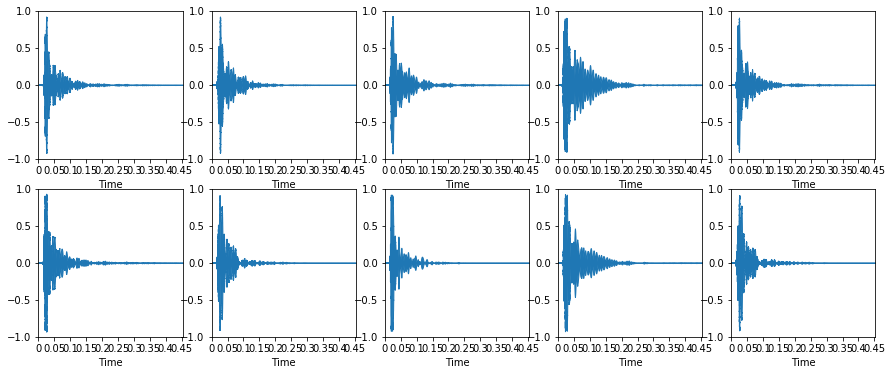

In [7]:
plt.figure(figsize=(15, 6))
for i, x in enumerate(kick_signals):
    plt.subplot(2, 5, i+1)
    librosa.display.waveplot(x[:10000])
    plt.ylim(-1, 1)

Display the snare drum signals:

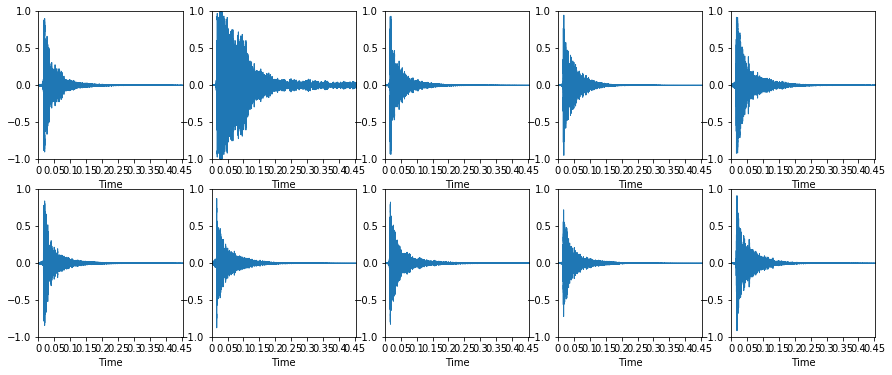

In [8]:
plt.figure(figsize=(15, 6))
for i, x in enumerate(snare_signals):
    plt.subplot(2, 5, i+1)
    librosa.display.waveplot(x[:10000])
    plt.ylim(-1, 1)

## Constructing a Feature Vector

A *feature vector* is simply a collection of features. Here is a simple function that constructs a two-dimensional feature vector from a signal:

In [9]:
def extract_features(signal):
    return (
        librosa.feature.zero_crossing_rate(signal)[0, 0],
        librosa.feature.spectral_centroid(signal)[0, 0],
    )

If we want to aggregate all of the feature vectors among signals in a collection, we can use a list comprehension as follows:

In [10]:
kick_zcr, kick_spec_cent = zip(*np.array([extract_features(x) for x in kick_signals]))
snare_zcr, snare_spec_cent = zip(*np.array([extract_features(x) for x in snare_signals]))

In [11]:
drum_samples = pd.DataFrame({'type': 10*['kick'] + 10*['snare']
                           ,'zcr' : np.concatenate((kick_zcr, snare_zcr))
                           ,'spec_cent' : np.concatenate((kick_spec_cent, snare_spec_cent))
                           })
drum_samples

,type,zcr,spec_cent
0,kick,0.066406,1095.504730
1,kick,0.067871,1139.916715
2,kick,0.074219,1206.814639
3,kick,0.069824,2222.538580
4,kick,0.070312,1153.224441
5,kick,0.087891,2092.705040
6,kick,0.067871,1126.891197
7,kick,0.057129,645.616698
8,kick,0.072754,1756.707939
9,kick,0.074219,1429.500329


Visualize the differences in features by plotting separate histograms for each of the classes:

In [12]:
assert sns.__version__ == '0.11.0', "Run: conda install -c anaconda seaborn"

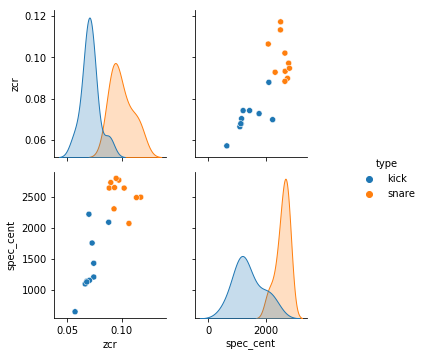

In [13]:
sns.pairplot(drum_samples, hue="type")

## Feature Scaling

The features that we used in the previous example included zero crossing rate and spectral centroid. These two features are expressed using different units. 

In [14]:
drum_samples[["zcr", "spec_cent"]].describe()

,zcr,spec_cent
count,20.000000,20.000000
mean,0.085181,1974.835133
std,0.017073,709.486724
min,0.057129,645.616698
25%,0.070190,1193.417089
50%,0.088135,2157.621810
75%,0.095337,2645.313349
max,0.117188,2802.183957


This discrepancy can pose problems when performing classification later. Therefore, we will normalize each feature vector to a common range and store the normalization parameters for later use.  

Many techniques exist for scaling your features. For now, we'll use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).  `MinMaxScaler` returns an array of scaled values such that each feature dimension is in the range -1 to 1.

Scale each feature dimension to be in the range -1 to 1:

In [15]:
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
drum_samples[['zcr', 'spec_cent']] = scaler.fit_transform(drum_samples[['zcr', 'spec_cent']])

In [16]:
drum_samples[["zcr", "spec_cent"]].describe()

,zcr,spec_cent
count,20.000000,20.000000
mean,-0.065854,0.232717
std,0.568542,0.657978
min,-1.000000,-1.000000
25%,-0.565041,-0.491970
50%,0.032520,0.402233
75%,0.272358,0.854518
max,1.000000,1.000000


Plot the scaled features:

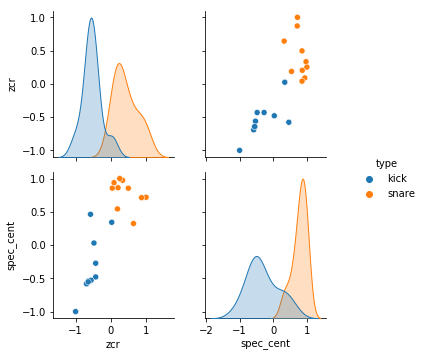

In [17]:
sns.pairplot(drum_samples, hue="type")

## Fitting and Testing a Model

#### Create a validation set

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 

data_train, data_test, labels_train, labels_test = train_test_split(drum_samples[["zcr", "spec_cent"]],drum_samples.type, test_size=0.3)

#### Fit a logistic regression model

In [19]:
# Initialize Classifier. 
LRC = LogisticRegression()
LRC.fit(data_train, labels_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Use the model to classify the test data

In [20]:
# Test classifier with the test data
predicted = LRC.predict(data_test)
predicted

array(['snare', 'kick', 'snare', 'kick', 'snare', 'snare'], dtype=object)

#### Evaluate the model's performance

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels_test, predicted))

             precision    recall  f1-score   support

       kick       1.00      0.67      0.80         3
      snare       0.75      1.00      0.86         3

avg / total       0.88      0.83      0.83         6



In [22]:

confusion_matrix(predicted, labels_test)

array([[2, 0],
       [1, 3]])

[&larr; Back to Index](index.html)